In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt 
from scipy.stats import gaussian_kde
sns.set(style="ticks",)
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 2.5})
%matplotlib inline

## Load Data

In [74]:
df = pd.read_csv('../assets/results/results.csv')
seg_time = np.load(r"C:\Users\Jeremy\Documents\UMICH\Research\UnrealRooftopLanding\AirSimCollectData\LidarRoofManualTest\SegmentationInfer\timings.npy")
seg_time[0] = seg_time[1]

df['Segmentation'] = seg_time[:len(df)]
df['t_smoothing'] = df['t_laplacian'] + df['t_bilateral']
df['t_Polylidar3D'] = df['t_mesh'] + df['t_smoothing'] + df['t_fastga_total'] + df['t_polylidar_planepoly'] #+ df['t_polylidar_filter']
df.head()


,Unnamed: 0,uid,sub_uid,building,pl_base_iou,pl_seg_gt_iou,pl_seg_infer_iou,computer,t_laplacian,t_bilateral,...,t_fastga_integrate,t_fastga_peak,t_polylidar_planepoly,t_polylidar_filter,t_classify_pointcloud,t_polylabel,iou_diff,Segmentation,t_smoothing,t_Polylidar3D
0,0,0,0,Building7_Example4,0.944352,0.951714,0.951714,desktop,0.3381,0.4378,...,1.0328,2.4543,0.9171,1.9874,1.7378,0.0653,-0.007362,23.1339,0.7759,5.3494
1,1,0,1,Building7_Example4,0.944716,0.951991,0.951991,desktop,0.3412,0.4172,...,1.0220,2.7461,0.9220,1.9652,2.0251,0.0641,-0.007276,23.1339,0.7584,5.6051
2,2,1,0,Building7_Example4,0.895104,0.909413,0.909413,desktop,0.3535,0.4851,...,0.9110,2.8399,1.2271,3.3182,1.8556,0.0670,-0.014309,21.0637,0.8386,6.0420
3,3,1,1,Building7_Example4,0.895526,0.909827,0.909821,desktop,0.3932,0.6129,...,0.9266,2.6866,1.1468,3.5799,1.8052,0.0640,-0.014302,20.7461,1.0061,5.9945
4,4,2,0,Building7_Example4,0.943267,0.949952,0.949952,desktop,0.4034,0.4230,...,0.7062,2.6693,0.7740,1.8442,1.4843,0.0540,-0.006685,22.7534,0.8264,5.1097


## Execution Time

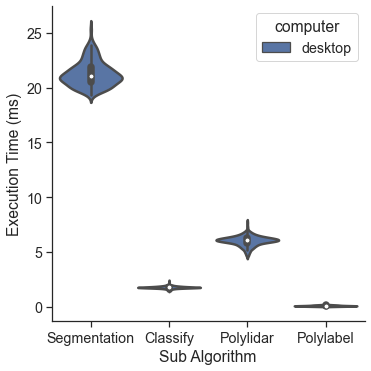

In [75]:
df_simple = df.rename(columns={"t_classify_pointcloud": "Classify", "t_Polylidar3D": "Polylidar", "t_polylabel": "Polylabel" })
df_simple = df_simple.melt(id_vars=["uid", "sub_uid", "computer"],
                                value_vars=['Segmentation','Classify', 'Polylidar', 'Polylabel'],
                                var_name="Sub Algorithm", 
                                value_name="Execution Time (ms)")
g = sns.catplot(data=df_simple, x='Sub Algorithm', hue='computer', y='Execution Time (ms)', kind='violin', legend_out=False)
g.savefig('../assets/imgs/alg_timings.pdf')

## Accuracy

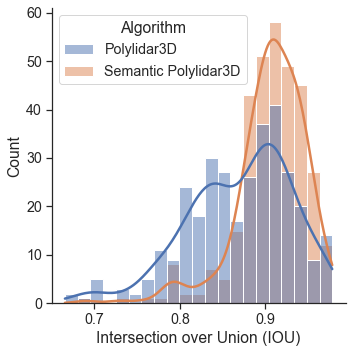

In [23]:
df = df.rename(columns={"pl_base_iou": "Polylidar3D", "pl_seg_infer_iou": "Semantic Polylidar3D"})
df_simple = df.melt(id_vars=["uid", "sub_uid"],
                                value_vars=['Polylidar3D', 'Semantic Polylidar3D'],
                                var_name="Algorithm", 
                                value_name="Intersection over Union (IOU)")
g = sns.displot(df_simple, x="Intersection over Union (IOU)", hue="Algorithm", fill=True, kde=True, facet_kws=dict(legend_out=False))
g.savefig('../assets/imgs/compare_algs.pdf')